In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from plot_keras_history import plot_history, show_history


warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('monthly_milk_production.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
production = data['Production'].astype(float).values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(production)

In [3]:
data

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


In [4]:
window_size = 12
X = []
y = []
target_dates = data.index[window_size:]

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, target_dates, test_size=0.2, shuffle=False
)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [5]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True,
          input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [6]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

rmse = np.sqrt(np.mean((y_test - predictions)**2))
print(f'RMSE: {rmse:.2f}')

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.1379 - val_loss: 0.0276
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0458 - val_loss: 0.0406
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0275 - val_loss: 0.0564
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0373 - val_loss: 0.0592
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0311 - val_loss: 0.0280
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0267 - val_loss: 0.0289
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0294 - val_loss: 0.0265
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0258 - val_loss: 0.0350
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0268 - val_loss: 0.0393
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0252 - val_loss: 0.0277
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0259 - val_loss: 0.0258
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0255 - val_l

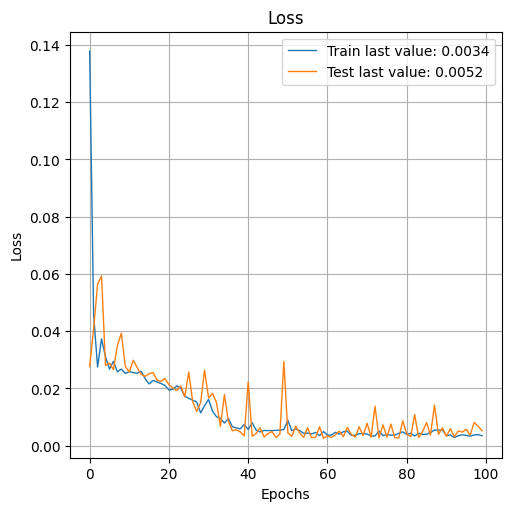

In [7]:
show_history(history)
plot_history(history)
plt.close()

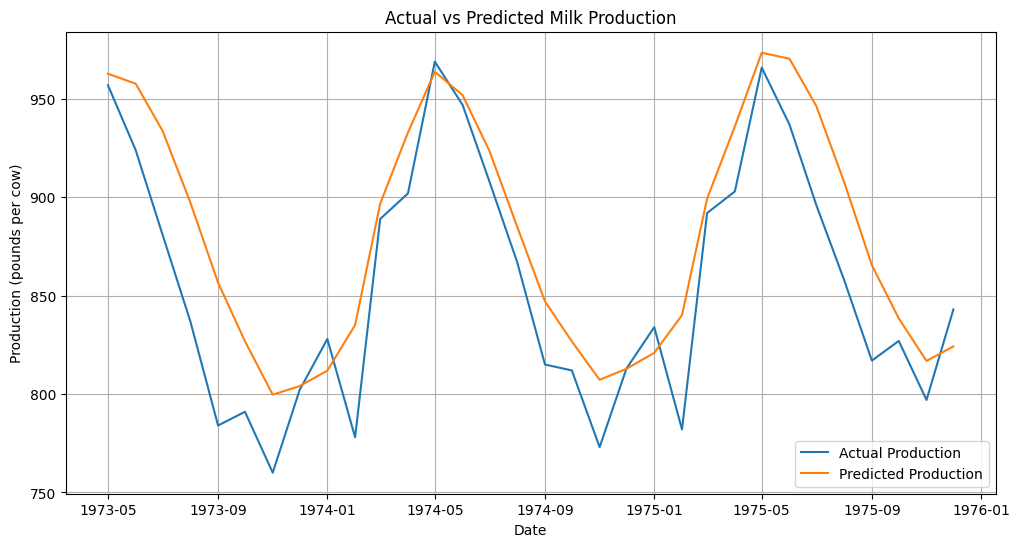

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual Production')
plt.plot(dates_test, predictions, label='Predicted Production')
plt.title('Actual vs Predicted Milk Production')
plt.xlabel('Date')
plt.ylabel('Production (pounds per cow)')
plt.legend()
plt.grid()
plt.show()